# Object detection with Retinanet

We are using this algorithm: https://github.com/fizyr/keras-retinanet

Retinanet is an object detection algorithm.

In addition to the requirements in the`requirements.txt` file, we also need to install `keras-retinanet` using 
```
pip install keras-retinanet
```

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from pyclouds.imports import *
from pyclouds.helpers import *
from pyclouds.zooniverse import *
from pyclouds.plot import *
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import pickle
from itertools import combinations

In [100]:
import imghdr

In [102]:
imghdr.what('/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070221_-135--114_-15--1.jpeg')

'jpeg'

## Prepare the data

We need to create a validation and training csv file that contains `filename, x1, y1, x2, y2, class`. So this is essentially one row per box. 

### Load and prepare the annotations CSV file.

Let's load the annotation file from the basic-analysis notebook. This is for the full dataset without the not-logged-in users.

In [7]:
annos_full = pd.read_pickle('../preprocessed_data/annos_full.pkl')

In [116]:
annos_full.head()

classification_id    user_name      user_id               user_ip  \
0         129486316  raspstephan  1.81491e+06  80bdc4acf6d39d1ea32e   
1         129486328  raspstephan  1.81491e+06  80bdc4acf6d39d1ea32e   
2         129486340  raspstephan  1.81491e+06  80bdc4acf6d39d1ea32e   
3         129486353  raspstephan  1.81491e+06  80bdc4acf6d39d1ea32e   
4         129487308  raspstephan  1.81491e+06  80bdc4acf6d39d1ea32e   

  workflow_id workflow_name workflow_version               created_at  \
0        8073  Full dataset            13.11  2018-11-01 08:28:49 UTC   
1        8073  Full dataset            13.11  2018-11-01 08:29:02 UTC   
2        8073  Full dataset            13.11  2018-11-01 08:29:18 UTC   
3        8073  Full dataset            13.11  2018-11-01 08:29:32 UTC   
4        8073  Full dataset            13.11  2018-11-01 08:40:30 UTC   

  gold_standard expert  ...        subject_set  \
0           NaN    NaN  ...   Region1_MAM_Aqua   
1           NaN    NaN  ...   Region3_DJF_Aqua   
2           NaN    NaN  ...  Region3_SON_Terra   
3           NaN    NaN  ...   Region1_DJF_Aqua   
4           NaN    NaN  ...   Region1_DJF_Aqua   

                                                  fn             datetime  \
0  Region1_MAM_Aqua/Aqua_CorrectedReflectance2007...  2018-11-01 08:28:49   
1  Region3_DJF_Aqua/Aqua_CorrectedReflectance2015...  2018-11-01 08:29:02   
2  Region3_SON_Terra/Terra_CorrectedReflectance20...  2018-11-01 08:29:18   
3  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...  2018-11-01 08:29:32   
4  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...  2018-11-01 08:40:30   

         x        y    width   height tool_label              started_at  \
0  190.188   11.954  957.534  490.034      Sugar 2018-11-01 08:28:37.425   
1  31.1041  541.538  1041.69  843.355      Sugar 2018-11-01 08:28:50.971   
2  1008.94  47.5113  1081.91   965.75     Flower 2018-11-01 08:29:03.018   
3  1172.62  436.477  916.031   509.42       Fish 2018-11-01 08:29:18.873   
4  1112.68  325.315  982.698  726.035     Flower 2018-11-01 08:40:20.517   

              finished_at  
0 2018-11-01 08:28:49.487  
1 2018-11-01 08:29:01.859  
2 2018-11-01 08:29:17.812  
3 2018-11-01 08:29:32.091  
4 2018-11-01 08:40:30.377  

[5 rows x 25 columns]

In [117]:
len(annos_full)

49132

In [9]:
# This is where the images are stored
IMGDIR = '/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/'

In [119]:
# Only extract the relevant quantities
annos_ret = annos_full[['fn', 'x', 'y', 'width', 'height', 'tool_label']]

In [120]:
annos_ret.head()

fn        x        y  \
0  Region1_MAM_Aqua/Aqua_CorrectedReflectance2007...  190.188   11.954   
1  Region3_DJF_Aqua/Aqua_CorrectedReflectance2015...  31.1041  541.538   
2  Region3_SON_Terra/Terra_CorrectedReflectance20...  1008.94  47.5113   
3  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...  1172.62  436.477   
4  Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...  1112.68  325.315   

     width   height tool_label  
0  957.534  490.034      Sugar  
1  1041.69  843.355      Sugar  
2  1081.91   965.75     Flower  
3  916.031   509.42       Fish  
4  982.698  726.035     Flower

#### Convert VIS filenames to IR filenames

In [121]:
annos_ret.fn = annos_ret.fn.apply(lambda fn: fn.replace('CorrectedReflectance','Brightness_Temp_Band31_Day'))

In [122]:
annos_ret.head()

fn        x        y  \
0  Region1_MAM_Aqua/Aqua_Brightness_Temp_Band31_D...  190.188   11.954   
1  Region3_DJF_Aqua/Aqua_Brightness_Temp_Band31_D...  31.1041  541.538   
2  Region3_SON_Terra/Terra_Brightness_Temp_Band31...  1008.94  47.5113   
3  Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_D...  1172.62  436.477   
4  Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_D...  1112.68  325.315   

     width   height tool_label  
0  957.534  490.034      Sugar  
1  1041.69  843.355      Sugar  
2  1081.91   965.75     Flower  
3  916.031   509.42       Fish  
4  982.698  726.035     Flower

#### Convert xywh to x1y1x2y2

In [123]:
annos_ret['width'] = annos_full.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[2], axis=1)
annos_ret['height'] = annos_full.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[3], axis=1)

In [124]:
# Additionally convert x and y to float type. Pickling seems to cast everything as object types
annos_ret['x'] = annos_ret['x'].astype(float)
annos_ret['y'] = annos_ret['y'].astype(float)

#### Prepend file path to filenames

In [125]:
annos_ret['fn'] = annos_ret['fn'].apply(lambda fn: IMGDIR + fn)

In [126]:
annos_ret.head()

fn            x           y  \
0  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   190.188187   11.954011   
1  /mnt/lustre02/work/mh0010/m300408/CloudClassif...    31.104063  541.537842   
2  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1008.944641   47.511284   
3  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1172.625000  436.476868   
4  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1112.680786  325.314545   

         width       height tool_label  
0  1147.721802   501.987610      Sugar  
1  1072.794678  1384.892700      Sugar  
2  2090.857178  1013.260986     Flower  
3  2088.655518   945.896851       Fish  
4  2095.378906  1051.349609     Flower

#### Fix obviously unrealistic values

Some of the coordinates are either less than 0 or larger than the max image size. We will clip them to their max/min allowed values.

In [127]:
annos_ret.describe()

x             y         width        height
count  43375.000000  43375.000000  43375.000000  43375.000000
mean     596.894456    397.153757   1527.317734   1014.643589
std      535.782875    340.494136    551.447971    336.465426
min     -625.336113   -401.602203     14.969124      0.257120
25%       50.362865     57.169327   1058.579529    745.107605
50%      503.460297    344.350464   1625.667969   1057.181396
75%     1043.826843    679.340698   2077.488037   1352.490295
max     2184.584961   1312.114868   3022.807861   1740.566650

First we will remove the entries where the lower left coordinates exceed the upper right coordinate of the image.

In [128]:
annos_ret = annos_ret[annos_ret.x.apply(lambda x: np.isnan(x) or x < 2099)]
annos_ret = annos_ret[annos_ret.y.apply(lambda x: np.isnan(x) or x < 2099)]

In [129]:
annos_ret.iloc[:7]

fn            x           y  \
0  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   190.188187   11.954011   
1  /mnt/lustre02/work/mh0010/m300408/CloudClassif...    31.104063  541.537842   
2  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1008.944641   47.511284   
3  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1172.625000  436.476868   
4  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1112.680786  325.314545   
5  /mnt/lustre02/work/mh0010/m300408/CloudClassif...          NaN         NaN   
6  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   902.583801   22.788500   

         width       height tool_label  
0  1147.721802   501.987610      Sugar  
1  1072.794678  1384.892700      Sugar  
2  2090.857178  1013.260986     Flower  
3  2088.655518   945.896851       Fish  
4  2095.378906  1051.349609     Flower  
5          NaN          NaN        NaN  
6  1576.635742   651.126648     Gravel

Then we will clip the values. We will also make sure that the upper right coordinates are at least 1. Zero would lead to a non-existing box.

In [130]:
# Fix wrong values
annos_ret['x'] = np.maximum(annos_ret['x'], 0)
annos_ret['y'] = np.maximum(annos_ret['y'], 0)
annos_ret['width'] = np.maximum(np.minimum(annos_ret['width'], 2100), 1)
annos_ret['height'] = np.maximum(np.minimum(annos_ret['height'], 1400), 1)

Finally, we will round the values to integers.

In [131]:
for c in ['x', 'y', 'width', 'height']:
    annos_ret[c] = annos_ret[c].round()

In [132]:
annos_ret.iloc[:7]

fn       x      y   width  \
0  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   190.0   12.0  1148.0   
1  /mnt/lustre02/work/mh0010/m300408/CloudClassif...    31.0  542.0  1073.0   
2  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1009.0   48.0  2091.0   
3  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1173.0  436.0  2089.0   
4  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1113.0  325.0  2095.0   
5  /mnt/lustre02/work/mh0010/m300408/CloudClassif...     NaN    NaN     NaN   
6  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   903.0   23.0  1577.0   

   height tool_label  
0   502.0      Sugar  
1  1385.0      Sugar  
2  1013.0     Flower  
3   946.0       Fish  
4  1051.0     Flower  
5     NaN        NaN  
6   651.0     Gravel

#### Some annoying technical stuff to save the values as integers

In [133]:
# First, replace all NaNs with empty strings
annos_ret.replace(np.nan, '', inplace=True)

In [134]:
annos_ret.iloc[:7]

fn     x    y width height  \
0  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   190   12  1148    502   
1  /mnt/lustre02/work/mh0010/m300408/CloudClassif...    31  542  1073   1385   
2  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1009   48  2091   1013   
3  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1173  436  2089    946   
4  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1113  325  2095   1051   
5  /mnt/lustre02/work/mh0010/m300408/CloudClassif...                           
6  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   903   23  1577    651   

  tool_label  
0      Sugar  
1      Sugar  
2     Flower  
3       Fish  
4     Flower  
5             
6     Gravel

Then cast all values as strings.

In [135]:
annos_ret[['x', 'y', 'width', 'height']] = annos_ret[['x', 'y', 'width', 'height']].astype(str)

In [136]:
annos_ret.head()

fn       x      y   width  \
0  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   190.0   12.0  1148.0   
1  /mnt/lustre02/work/mh0010/m300408/CloudClassif...    31.0  542.0  1073.0   
2  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1009.0   48.0  2091.0   
3  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1173.0  436.0  2089.0   
4  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1113.0  325.0  2095.0   

   height tool_label  
0   502.0      Sugar  
1  1385.0      Sugar  
2  1013.0     Flower  
3   946.0       Fish  
4  1051.0     Flower

Unfortunately, we need to remove the .0 at the end using some ugly trick.

In [137]:
for c in ['x', 'y', 'width', 'height']:
    annos_ret[c] = annos_ret[c].apply(lambda s: s[:-2] if len(s)>0 else s)

In [138]:
annos_ret.head()

fn     x    y width height  \
0  /mnt/lustre02/work/mh0010/m300408/CloudClassif...   190   12  1148    502   
1  /mnt/lustre02/work/mh0010/m300408/CloudClassif...    31  542  1073   1385   
2  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1009   48  2091   1013   
3  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1173  436  2089    946   
4  /mnt/lustre02/work/mh0010/m300408/CloudClassif...  1113  325  2095   1051   

  tool_label  
0      Sugar  
1      Sugar  
2     Flower  
3       Fish  
4     Flower

In [139]:
len(annos_ret)

49130

Test if all files exists in directory

In [105]:
from tqdm import tqdm as tqdm
for fn in tqdm(annos_ret.fn):
    if os.path.isfile(fn):
        if imghdr.what(fn) == None:
            print(fn)
        continue
    else:
        print(fn)

 28%|██▊       | 13831/49130 [00:51<05:18, 110.89it/s]

/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg
/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg


 29%|██▊       | 14123/49130 [00:53<04:48, 121.44it/s]

/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg
/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg


 58%|█████▊    | 28663/49130 [02:36<02:32, 134.21it/s]

/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg
/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg


 71%|███████▏  | 35110/49130 [03:14<01:16, 183.83it/s]

/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg
/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg


100%|██████████| 49130/49130 [04:38<00:00, 176.34it/s]


Now we have the rows in the format we need.

### Split into train and valid

Next we need to get a reproducible train valid split. The order of images is already random in the way they were presented on Zooniverse. So we will just make a hard cut. Later we can separate different regions.

In [140]:
# Get a list of all subjects
all_subj = list(set(annos_full.fn.apply(lambda fn: fn.replace('CorrectedReflectance','Brightness_Temp_Band31_Day'))))

In [141]:
all_subj[:5]

['Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20110223_-135--114_-15--1.jpeg',
 'Region3_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20071202_-135--114_-15--1.jpeg',
 'Region1_MAM_Aqua/Aqua_Brightness_Temp_Band31_Day20080328_-61--40_10-24.jpeg',
 'Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20151222_-61--40_10-24.jpeg',
 'Region1_DJF_Terra/Terra_Brightness_Temp_Band31_Day20161229_-61--40_10-24.jpeg']

Unfortunately there are some corrupted image files (probably just on my end). As you can see below, the number is not significant. So we will just throw them out.

In [142]:
# # Test image files
# bad_files = []
# for s in tqdm(all_subj):
#     try:
#         img = np.asarray(Image.open(SSDDIR + s).convert('RGB'))
#     except:
#         bad_files.append(s)

In [152]:
bad_files = ['Region3_SON_Aqua/Aqua_Brightness_Temp_Band31_Day20151003_-135--114_-15--1.jpeg',
 'Region3_SON_Aqua/Aqua_Brightness_Temp_Band31_Day20091028_-135--114_-15--1.jpeg',
 'Region1_MAM_Terra/Terra_Brightness_Temp_Band31_Day20170302_-61--40_10-24.jpeg',
 'Region1_MAM_Terra/Terra_Brightness_Temp_Band31_Day20070512_-61--40_10-24.jpeg',
 'Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20170221_-61--40_10-24.jpeg',
 'Region2_DJF_Terra/Terra_Brightness_Temp_Band31_Day20071208_159-180_8-22.jpeg',
 'Region3_SON_Aqua/Aqua_Brightness_Temp_Band31_Day20161022_-135--114_-15--1.jpeg',
 'Region3_SON_Terra/Terra_Brightness_Temp_Band31_Day20091021_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20130116_-61--40_10-24.jpeg',
 'Region2_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20101201_159-180_8-22.jpeg',
 'Region1_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070227_-61--40_10-24.jpeg',
 'Region1_MAM_Terra/Terra_Brightness_Temp_Band31_Day20130308_-61--40_10-24.jpeg',
 'Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20110211_-61--40_10-24.jpeg',
 'Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20140123_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20071217_-61--40_10-24.jpeg',
 'Region2_DJF_Terra/Terra_Brightness_Temp_Band31_Day20170224_159-180_8-22.jpeg',
 'Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20080101_-135--114_-15--1.jpeg',
 'Region3_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20071218_-135--114_-15--1.jpeg',
 'Region3_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20071201_-135--114_-15--1.jpeg',
 'Region2_DJF_Terra/Terra_Brightness_Temp_Band31_Day20171213_159-180_8-22.jpeg',
 'Region3_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20090111_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_Brightness_Temp_Band31_Day20071207_-61--40_10-24.jpeg',
 'Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070103_-135--114_-15--1.jpeg',
 'Region2_DJF_Terra/Terra_Brightness_Temp_Band31_Day20161220_159-180_8-22.jpeg',
 'Region3_DJF_Terra/Terra_Brightness_Temp_Band31_Day20070129_-135--114_-15--1.jpeg']

In [1]:
len(all_subj)

NameError: name 'all_subj' is not defined

In [154]:
all_subj = [s for s in all_subj if s not in bad_files] #~np.in1d(all_subj, bad_files)# 

In [155]:
len(all_subj)

9719

#### Random

In total there are around 10k images. Let's do a random 80/20 split. The images are already in random order it seems.

In [156]:
train_subj = all_subj[:8000]
valid_subj = all_subj[8000:]

In [157]:
with open('/home/mpim/m300408/subj_fns_random.pkl', 'wb') as f:
    pickle.dump((all_subj, train_subj, valid_subj), f)

Now we need to pick all corresponding annotations.

In [158]:
annos_ret_train = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in train_subj)]

In [159]:
annos_ret_valid = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in valid_subj)]

In [160]:
len(annos_ret), len(annos_ret_train), len(annos_ret_valid)

(49130, 40156, 8852)

In [161]:
annos_ret_train.to_csv('/home/mpim/m300408/annos_ret_train_IR_random.csv', header=False, index=False)

In [162]:
annos_ret_valid.to_csv('/home/mpim/m300408/annos_ret_valid_IR_random.csv', header=False, index=False)

#### By region

We can also split the train validation sets by region, which gives us a more realistic performance check for the algorithm.

In [163]:
subj_id2name = {60811:'Region1_DJF_Aqua',60812:'Region1_DJF_Terra',60813: 'Region1_MAM_Aqua',
                60814: 'Region1_MAM_Terra',60815:'Region2_DJF_Aqua',60816:'Region2_DJF_Terra',
                60817:'Region3_DJF_Aqua', 60818:'Region3_DJF_Terra',60819:'Region3_SON_Aqua',
                60835: 'Region3_SON_Terra'}

In [164]:
valid_subj = [s for s in all_subj if 'Region1' in s]
train_subj = [s for s in all_subj if 'Region1' not in s]

In [165]:
len(valid_subj), len(train_subj)

(3893, 5826)

In [166]:
annos_ret_train = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in train_subj)]

In [167]:
annos_ret_valid = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in valid_subj)]

In [168]:
len(annos_ret), len(annos_ret_train), len(annos_ret_valid)

(49130, 29710, 19298)

In [169]:
annos_ret_train.to_csv('/home/mpim/m300408/annos_ret_train_IR_region.csv', header=False, index=False)

In [170]:
annos_ret_valid.to_csv('/home/mpim/m300408/annos_ret_valid_IR_region.csv', header=False, index=False)

### Class csv

Finally, we also need a csv file with all the classes.

In [148]:
clas_df = pd.DataFrame(data={'name': ['Flower', 'Fish', 'Gravel', 'Sugar'], 'id': range(4)})

In [149]:
clas_df

name  id
0  Flower   0
1    Fish   1
2  Gravel   2
3   Sugar   3

In [150]:
clas_df.to_csv('/home/mpim/m300408/clas_ret.csv', header=False, index=False)

## Retinanet experiments

Here is the code I am using to run the keras-retinanet version. 

With a batch size of 4 and a training dataset size of around 40k, you would get around 10k steps per epoch. For more frequent evaluation/saving, I will chose 2k.


Note that I made slight changes to the keras-retinanet code to allow for variable anchor sizes and seeing the actual validation score, not just the mAP. Contact me if you are interested in those.

For the "best" network version, I don't need any of these though. 

Here is the command line prompt to train a model. Of course you need to change the paths for your image and csv locations. A batch size of four with a max image size of 1050 requires 15.4GB of GPU RAM. One epoch takes around 1.5h on a Quadro P5000:

```shell
retinanet-train \
--gpu 1 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp0/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_region.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_region.csv
```

Below are some of my hyper-parameter experiments...

### Experiment 1: My best guess

```shell
keras_retinanet/bin/train.py \
--gpu 0 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--random-transform \
--min_anchor_size 64 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp1/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 13/20
2000/2000 [==============================] - 2795s 1s/step - loss: 2.2014 - regression_loss: 1.8453 - classification_loss: 0.3561
1509 instances of class Flower with average precision: 0.1933
1754 instances of class Fish with average precision: 0.1004
1844 instances of class Gravel with average precision: 0.1084
2725 instances of class Sugar with average precision: 0.0872
mAP: 0.1223

val_loss: 2.5161 - val_regression_loss: 2.1244 - val_classification_loss: 0.3917


Epoch 20/20
2000/2000 [==============================] - 2570s 1s/step - loss: 2.1367 - regression_loss: 1.7926 - classification_loss: 0.3442
1509 instances of class Flower with average precision: 0.1337
1754 instances of class Fish with average precision: 0.0973
1844 instances of class Gravel with average precision: 0.0835
2725 instances of class Sugar with average precision: 0.0862
mAP: 0.1002

val_loss: 2.5526 - val_regression_loss: 2.1750 - val_classification_loss: 0.3777

```

### Experiment 2: Exp 1 with nms_iou=0.3

```shell
keras_retinanet/bin/train.py \
--gpu 1 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--random-transform \
--min_anchor_size 64 \
--nms_iou 0.3 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp2/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 2678s 1s/step - loss: 2.1389 - regression_loss: 1.7934 - classification_loss: 0.3455
1509 instances of class Flower with average precision: 0.0979
1754 instances of class Fish with average precision: 0.0590
1844 instances of class Gravel with average precision: 0.0496
2725 instances of class Sugar with average precision: 0.0424
mAP: 0.0622

val_loss: 2.5312 - val_regression_loss: 2.1484 - val_classification_loss: 0.3828
```

### Experiment 3: Exp 1 without data augmentation

```shell
keras_retinanet/bin/train.py \
--gpu 2 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--min_anchor_size 64 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp3/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 1913s 957ms/step - loss: 1.8668 - regression_loss: 1.5396 - classification_loss: 0.3271
1509 instances of class Flower with average precision: 0.1712
1754 instances of class Fish with average precision: 0.1005
1844 instances of class Gravel with average precision: 0.1047
2725 instances of class Sugar with average precision: 0.0990
mAP: 0.1189

val_loss: 2.1677 - val_regression_loss: 1.8139 - val_classification_loss: 0.3537
```

### Experiment 4: Exp 1 without default anchor sizes

```shell
keras_retinanet/bin/train.py \
--gpu 3 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp4/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 2595s 1s/step - loss: 1.8765 - regression_loss: 1.5490 - classification_loss: 0.3275
1509 instances of class Flower with average precision: 0.4345
1754 instances of class Fish with average precision: 0.3552
1844 instances of class Gravel with average precision: 0.3331
2725 instances of class Sugar with average precision: 0.3953
mAP: 0.3795

val_loss: 2.1927 - val_regression_loss: 1.8330 - val_classification_loss: 0.3597
```

### Experiment 5: Exp 4 with region validation

```shell
keras_retinanet/bin/train.py \
--gpu 3 \
--valid \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp5/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_region.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_region.csv
```

```
Epoch 1/1
2/2 [==============================] - 139s 70s/step - loss: 1.8181 - regression_loss: 1.4486 - classification_loss: 0.3694 - val_loss: 2.2597 - val_regression_loss: 1.8873 - val_classification_loss: 0.3724
803 instances of class Flower with average precision: 0.3934
2777 instances of class Fish with average precision: 0.3552
2621 instances of class Gravel with average precision: 0.3225
3846 instances of class Sugar with average precision: 0.3828
mAP: 0.3635
```

### Experiment 6: Exp 4 from snapshot with larger img_size

```shell
keras_retinanet/bin/train.py \
--snapshot  /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp4/resnet50_csv_20.h5 \
--valid \
--gpu 2 \
--epochs 20 \
--batch-size 2 \
--steps 2000 \
--image-max-side 1600 \
--image-min-side 1600 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp6/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
val_loss: 2.1770 - val_regression_loss: 1.8083 - val_classification_loss: 0.3686
1509 instances of class Flower with average precision: 0.4351
1754 instances of class Fish with average precision: 0.3429
1844 instances of class Gravel with average precision: 0.3260
2725 instances of class Sugar with average precision: 0.3980
mAP: 0.3755
```

### Experiment 7: Using Hauke's IR filtered dataset

```shell
keras_retinanet/bin/train.py \
--gpu 0 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp7/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ir_train_region.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ir_valid_region.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 1720s 860ms/step - loss: 1.8002 - regression_loss: 1.4497 - classification_loss: 0.3505
593 instances of class Flower with average precision: 0.3561
1984 instances of class Fish with average precision: 0.3151
2074 instances of class Gravel with average precision: 0.2785
3017 instances of class Sugar with average precision: 0.3215
mAP: 0.3178
```

## Check out predictions
Switch to GPU node (e.g. run jupyter-lab on allocated gpu node)

In [1]:
import keras_retinanet
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pandas as pd

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
SAVEDIR = '../pretrained_weights/retinanet/'

In [4]:
!ls $SAVEDIR

ls: cannot access ../pretrained_weights/retinanet/: No such file or directory


### Load IR model

In [3]:
# adjust this to point to your downloaded/trained model
model_path = '/home/mpim/m300408/inference/resnet50_csv_03.h5'

In [4]:
# load retinanet model
#model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
# model = models.load_model(model_path, backbone_name='resnet50')
# or use
#!keras_retinanet/bin/convert_model.py /path/to/training/model.h5 /path/to/save/inference/model.h5
model = models.load_model(model_path, backbone_name='resnet50')

#print(model.summary())

# load label to names mapping for visualization purposes

#labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {i: l for i, l in enumerate(['Flower', 'Fish', 'Gravel', 'Sugar'])}

/work/mh0010/m300408/anaconda3/envs/github_sugar/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Plot some predictions

In [34]:
val_df = pd.read_csv('/home/mpim/m300408/annos_ret_valid_region.csv', header=None)

In [35]:
val_fns = list(val_df[0].unique()); len(val_fns)

1931

In [36]:
val_fns_ir = [file.replace('CorrectedReflectance','Brightness_Temp_Band31_Day').replace('VIS','IR') for file in val_fns]

In [31]:
def get_retinanet_preds(model, fn, thresh=0.5, min_side=800, max_side=1050):
    image = read_image_bgr(fn)
    image = preprocess_image(image)
    image, scale = resize_image(image, min_side, max_side)
    boxes, scores, labels = [o[0] for o in model.predict_on_batch(np.expand_dims(image, axis=0))]
    boxes /= scale
    boxes = boxes[scores > thresh]
    boxes = [xy2wh(*b) for b in boxes]
    labels = labels[scores > thresh]
    labels = [labels_to_names[i] for i in labels]
    scores = scores[scores > thresh]
    return np.array(boxes), labels, scores

In [32]:
def plot_img_from_fn_and_boxes(fn, boxes, labels, scores, figsize=(18, 15), show_labels=True):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    img = Image.open(fn)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(boxes.shape[0]):
        rect = patches.Rectangle((boxes[i, 0], boxes[i, 1]), boxes[i, 2], boxes[i, 3],
                                 facecolor='none',
                                 edgecolor=np.array(l2c[labels[i]]) / 255, lw=2)
        ax.add_patch(rect)
        if show_labels:
            s = labels[i] + ' - Retinanet - ' + str(scores[i])[:4]
            txt = ax.text(boxes[i, 0], boxes[i, 1], s, color='white', fontsize=15, va='top')
            txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])

In [30]:
def plot_retinanet(model, fn, thresh=0.5):
    boxes, labels, scores = get_retinanet_preds(model, fn, thresh)
    plot_img_from_fn_and_boxes(fn, boxes, labels, scores)

In [10]:
fn2id = {IMGDIR + r.fn: r.subject_ids for i, r in annos_full.iterrows()}

In [133]:
image_ind_201712 = []
for s,string in enumerate(np.array(list(fn2id.keys()))):
    if '201712' in string and 'Region1' in string:
        image_ind_201712.append(s)

In [226]:
image_example =0

In [227]:
list(fn2id.keys())[image_ind_201712[image_example]]

'/mnt/lustre02/work/mh0010/m300408/CloudClassificationImages/IR/Region1_DJF_Terra/Terra_CorrectedReflectance20171215_-61--40_10-24.jpeg'

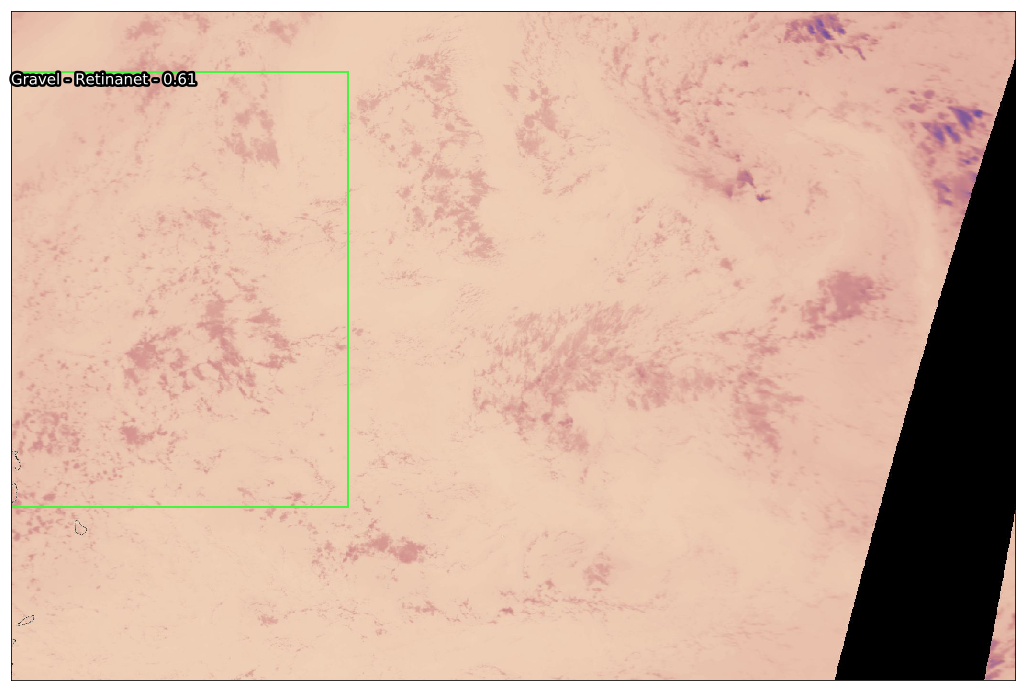

In [228]:
# plot_retinanet(model, val_fns_ir[image_example])
plot_retinanet(model, list(fn2id.keys())[image_ind_201712[image_example]].replace('CorrectedReflectance','Brightness_Temp_Band31_Day'))

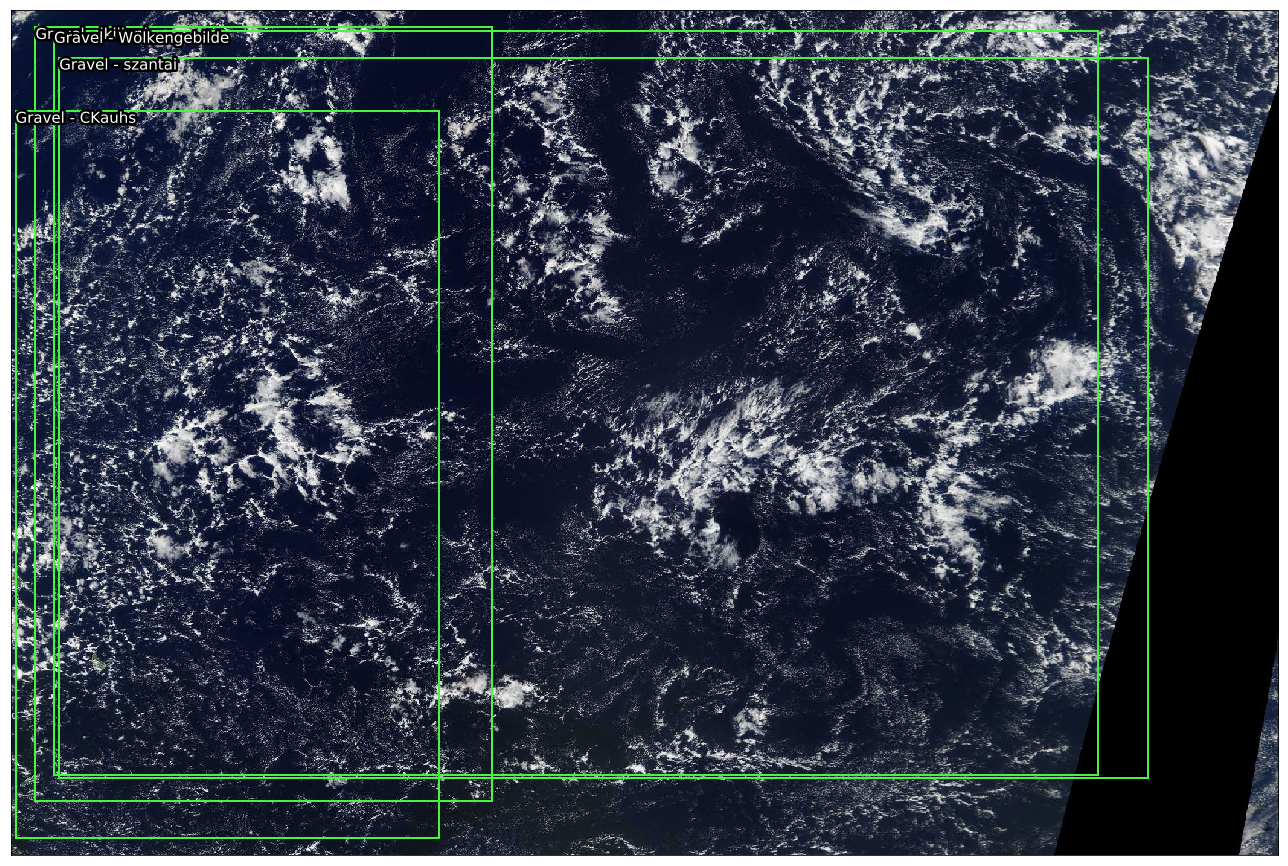

In [229]:
# plot_img_with_annos(fn2id[val_fns_ir[image_example].replace('Brightness_Temp_Band31_Day','CorrectedReflectance')], IMGDIR.replace('IR','VIS'), annos_full)
plot_img_with_annos(fn2id[list(fn2id.keys())[image_ind_201712[image_example]].replace('Brightness_Temp_Band31_Day','CorrectedReflectance')], IMGDIR.replace('IR','VIS'), annos_full)

### Load VIS model for intercomparison

In [189]:
VIS_model_path = '/home/mpim/m300408/CloudClassification/exp5_resnet50_csv_20_inference.h5'
VIS_model = models.load_model(VIS_model_path, backbone_name='resnet50')

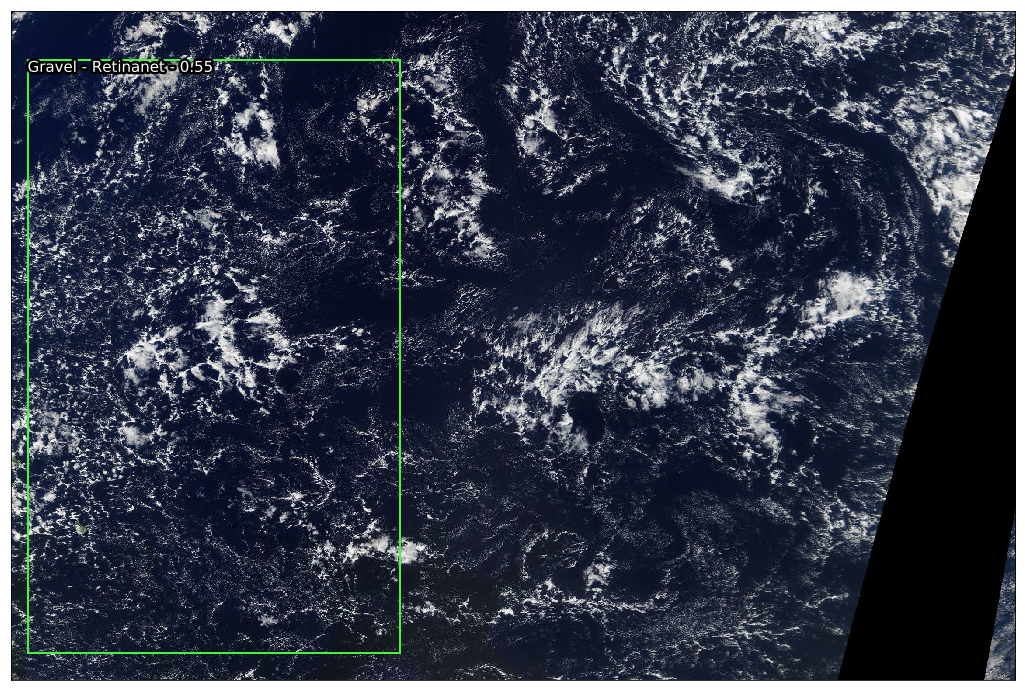

In [230]:
# plot_retinanet(VIS_model, val_fns_ir[image_example].replace('Brightness_Temp_Band31_Day','CorrectedReflectance').replace('IR','VIS'))
plot_retinanet(VIS_model, list(fn2id.keys())[image_ind_201712[image_example]].replace('Brightness_Temp_Band31_Day','CorrectedReflectance').replace('IR','VIS'))

### Transfer model from MODIS IR dataset to GOES16 IR dataset
By applying the model to the geostationary satellite GOES16 it would be possible to study the diurnal cycle of the patterns. While MODIS gives in the IR only for overpasses a day, GOES16 delivers images with a temporal resolution of 15 min and covers always the complete domain.

#### MODIS

(2356, 1594)
1.121904761904762
[2100.         1420.79796265]


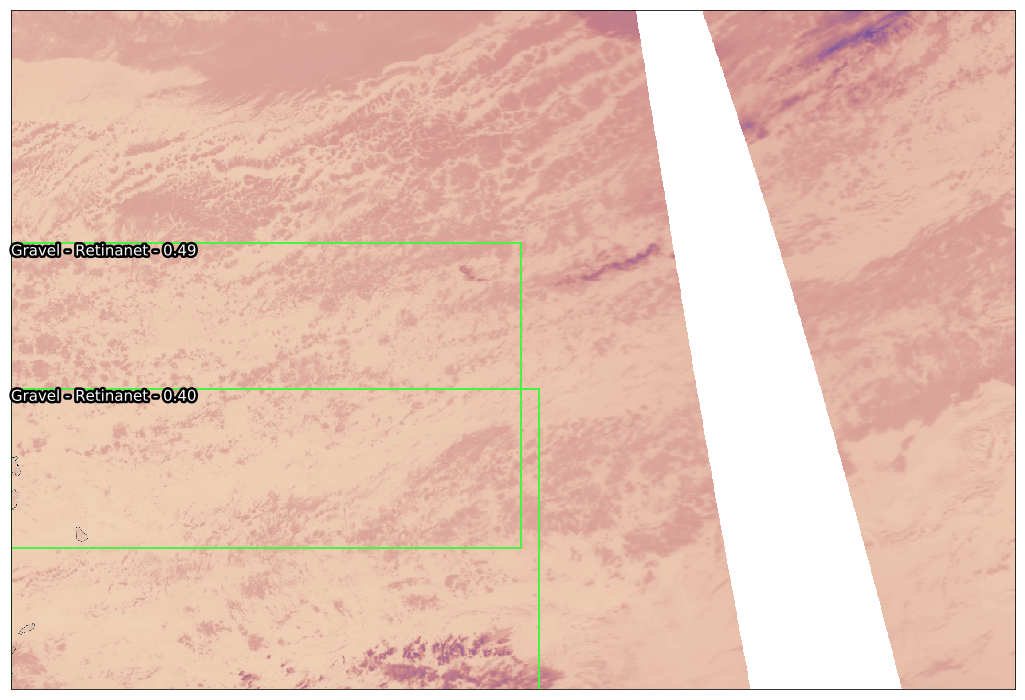

In [67]:
img = Image.open('/home/mpim/m300408/snapshot_MODIS.png')

sz = img.size; print(sz)

scale = sz[0] / 2100; print(scale)

new_size = np.array(sz) / scale; print(new_size)

img_small = img.resize(new_size.astype(int))
img_small.save('snapshot_small.png')
plot_retinanet(model, 'snapshot_small.png', 0.4)

#### GOES16
For a comparable timestamp (about 10 minutes before the MODIS overpass) the GOES16 image is used as input. Since the model has been trained so far with the RGB values, the GOES16 IR data has been colored identically.

(2244, 1489)
1.0685714285714285
[2100.         1393.44919786]


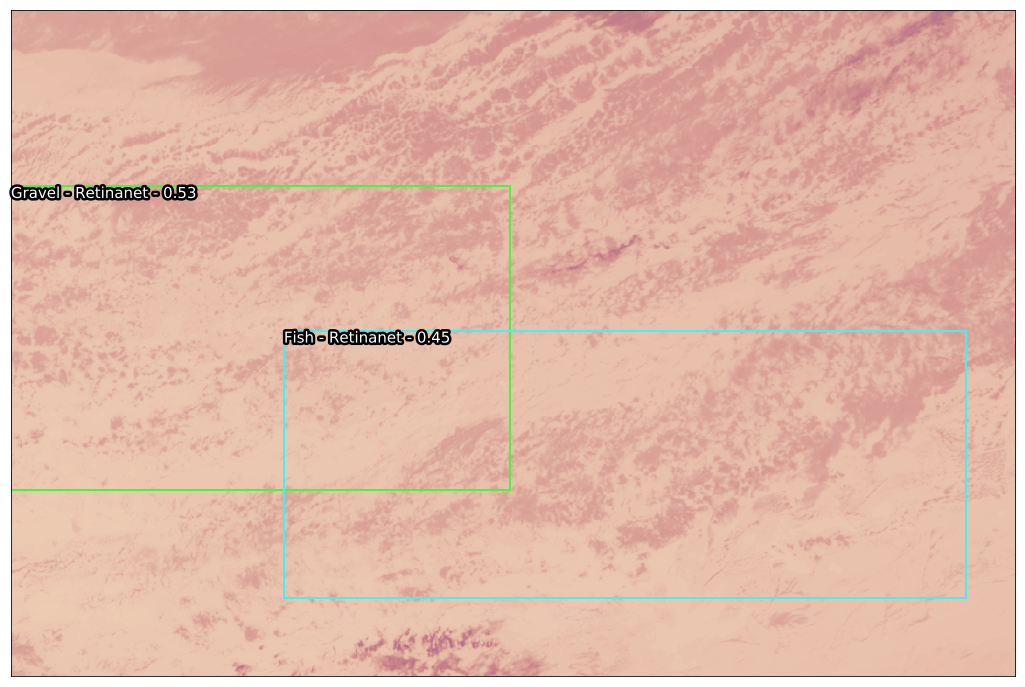

In [66]:
img = Image.open('/home/mpim/m300408/GOES16__C13__20190101Z0205__1546308355.0200.png')

sz = img.size; print(sz)

scale = sz[0] / 2100; print(scale)

new_size = np.array(sz) / scale; print(new_size)

img_small = img.resize(new_size.astype(int))
img_small.save('snapshot_small.png')
plot_retinanet(model, 'snapshot_small.png', 0.4)

(2244, 1489)
1.0685714285714285
[2100.         1393.44919786]


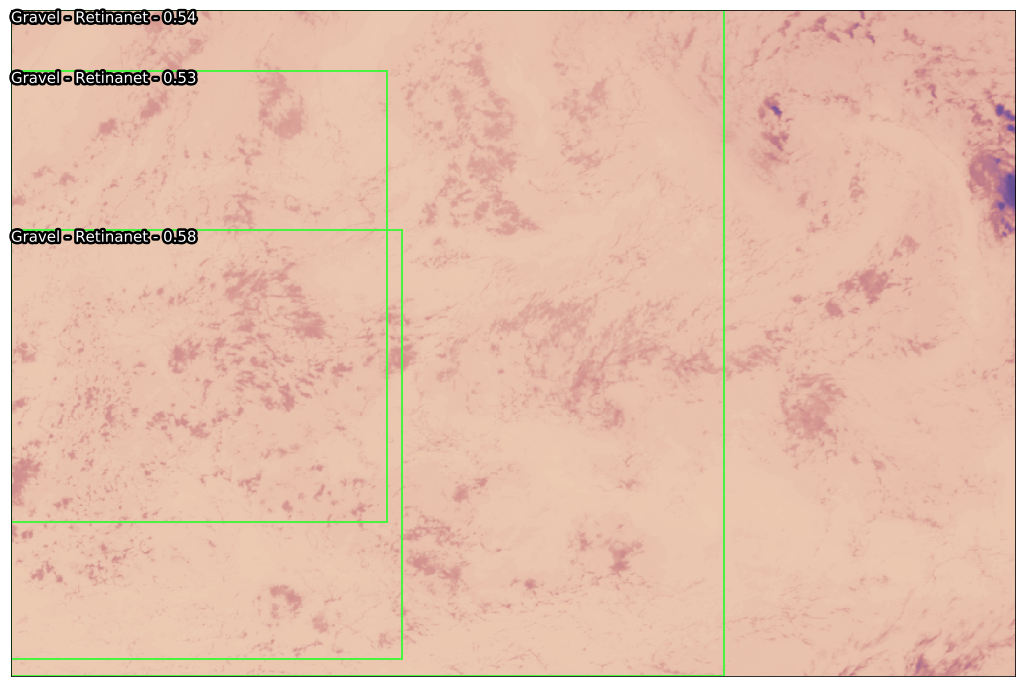

In [231]:
img = Image.open('/home/mpim/m300408/GOES16__C13__20171215Z1106__1513335961.0200.png')

sz = img.size; print(sz)

scale = sz[0] / 2100; print(scale)

new_size = np.array(sz) / scale; print(new_size)

img_small = img.resize(new_size.astype(int))
img_small.save('snapshot_small.png')
plot_retinanet(model, 'snapshot_small.png', 0.5)